# Environment Setup

In [1]:
from keras.models import Model
from keras.layers import Embedding, Input, Dense, Flatten, Concatenate, Multiply, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Mounted at /content/drive
Num GPUs Available:  0


# Data Ingestion For NCF Model

In [56]:
wrk_dir = './drive/MyDrive/CS 7643 Project/'
user_topic_cluster_matrix = np.load(wrk_dir + 'Data/clustered_user_matrix_v3_rr.npy')
product_topic_cluster_matrix = np.load(wrk_dir + 'Data/clustered_prod_matrix_v3_rr.npy')
user_product_matrix = np.load(wrk_dir + 'Data/final_mat_v3_rr.npy')

In [57]:
user_topic_cluster_matrix = user_topic_cluster_matrix[0:5000]
product_topic_cluster_matrix = product_topic_cluster_matrix[0:5000]
user_product_matrix = user_product_matrix[0:5000, :5000]

In [58]:
print(product_topic_cluster_matrix.shape)
print(user_topic_cluster_matrix.shape)
print(user_product_matrix.shape)

(5000, 768)
(5000, 768)
(5000, 5000)


# MODEL

In [59]:
num_users, user_embedding_size = user_topic_cluster_matrix.shape
num_products, product_embedding_size = product_topic_cluster_matrix.shape

# Define the model

user_input = Input(shape=(1,), dtype='int32', name='user_input')
product_input = Input(shape=(1,), dtype='int32', name='product_input')

user_embedding = Embedding(input_dim=num_users,
                           output_dim=user_embedding_size,
                           weights=[user_topic_cluster_matrix], trainable=True)(user_input)
product_embedding = Embedding(input_dim=num_products,
                              output_dim=product_embedding_size,
                              weights=[product_topic_cluster_matrix],
                              trainable=True)(product_input)

user_vecs = Flatten()(user_embedding)
product_vecs = Flatten()(product_embedding)

# Multiply the vectors
mul = Multiply()([user_vecs, product_vecs])

# Concatenate the vectors
concat = Concatenate()([user_vecs, product_vecs, mul])
# concat = Concatenate()([user_vecs, product_vecs])

# Add dropout for regularization
dropout = Dropout(0.5)(concat)

# Add dense layers
dense = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dropout)
dense = Dropout(0.5)(dense)
# dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dense)
# dense = Dropout(0.5)(dense)
dense = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dense)

prediction = Dense(1, activation='sigmoid')(dense)

# Build and compile model
model = Model(inputs=[user_input, product_input], outputs=prediction)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [60]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 1, 768)         │      3,840,000 │ user_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 1, 768)         │      3,840,000 │ product_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 768)            │              0 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 768)            │              0 │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 768)            │              0 │ flatten_6[0][0],       │
│                           │                        │                │ flatten_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 2304)           │              0 │ flatten_6[0][0],       │
│ (Concatenate)             │                        │                │ flatten_7[0][0],       │
│                           │                        │                │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 2304)           │              0 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │        295,040 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │          4,128 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             33 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,979,201 (30.44 MB)

 Trainable params: 7,979,201 (30.44 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Prepare the data
user_ids, product_ids = np.nonzero(user_product_matrix >= 0) # assuming all interactions are non-negative
interactions = user_product_matrix[user_ids, product_ids]

# Split the data into training and testing sets
train_user_ids, test_user_ids, train_product_ids, test_product_ids, train_interactions, test_interactions = train_test_split(user_ids,
                                                                                                                             product_ids,
                                                                                                                             interactions,
                                                                                                                             test_size=0.2,
                                                                                                                             random_state=42)

In [62]:
# If want to retrain model set the following to TRUE
retrain_model = False

if retrain_model:
  # Create an EarlyStopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)


  # Create a ModelCheckpoint callback
  checkpoint = ModelCheckpoint(wrk_dir + 'models/ncf_model_v3_dropouts_weight_decay_{epoch:03d}.keras',
                              verbose=1,
                              monitor='val_loss',
                              save_best_only=True,
                              mode='auto')

  # Train the model
  model.fit([train_user_ids, train_product_ids],
            train_interactions,
            batch_size=512,
            epochs=1,
            verbose=1,
            validation_split=0.2)
  # ,callbacks=[checkpoint, early_stopping])
  model.save(wrk_dir + 'models/ncf_model_v3_rr.keras')
else:
  model = load_model(wrk_dir + 'models/ncf_model_v3_rr.keras')



31250/31250 ━━━━━━━━━━━━━━━━━━━━ 1036s 33ms/step - loss: 0.0259 - val_loss: 0.0056


## Model Architecture

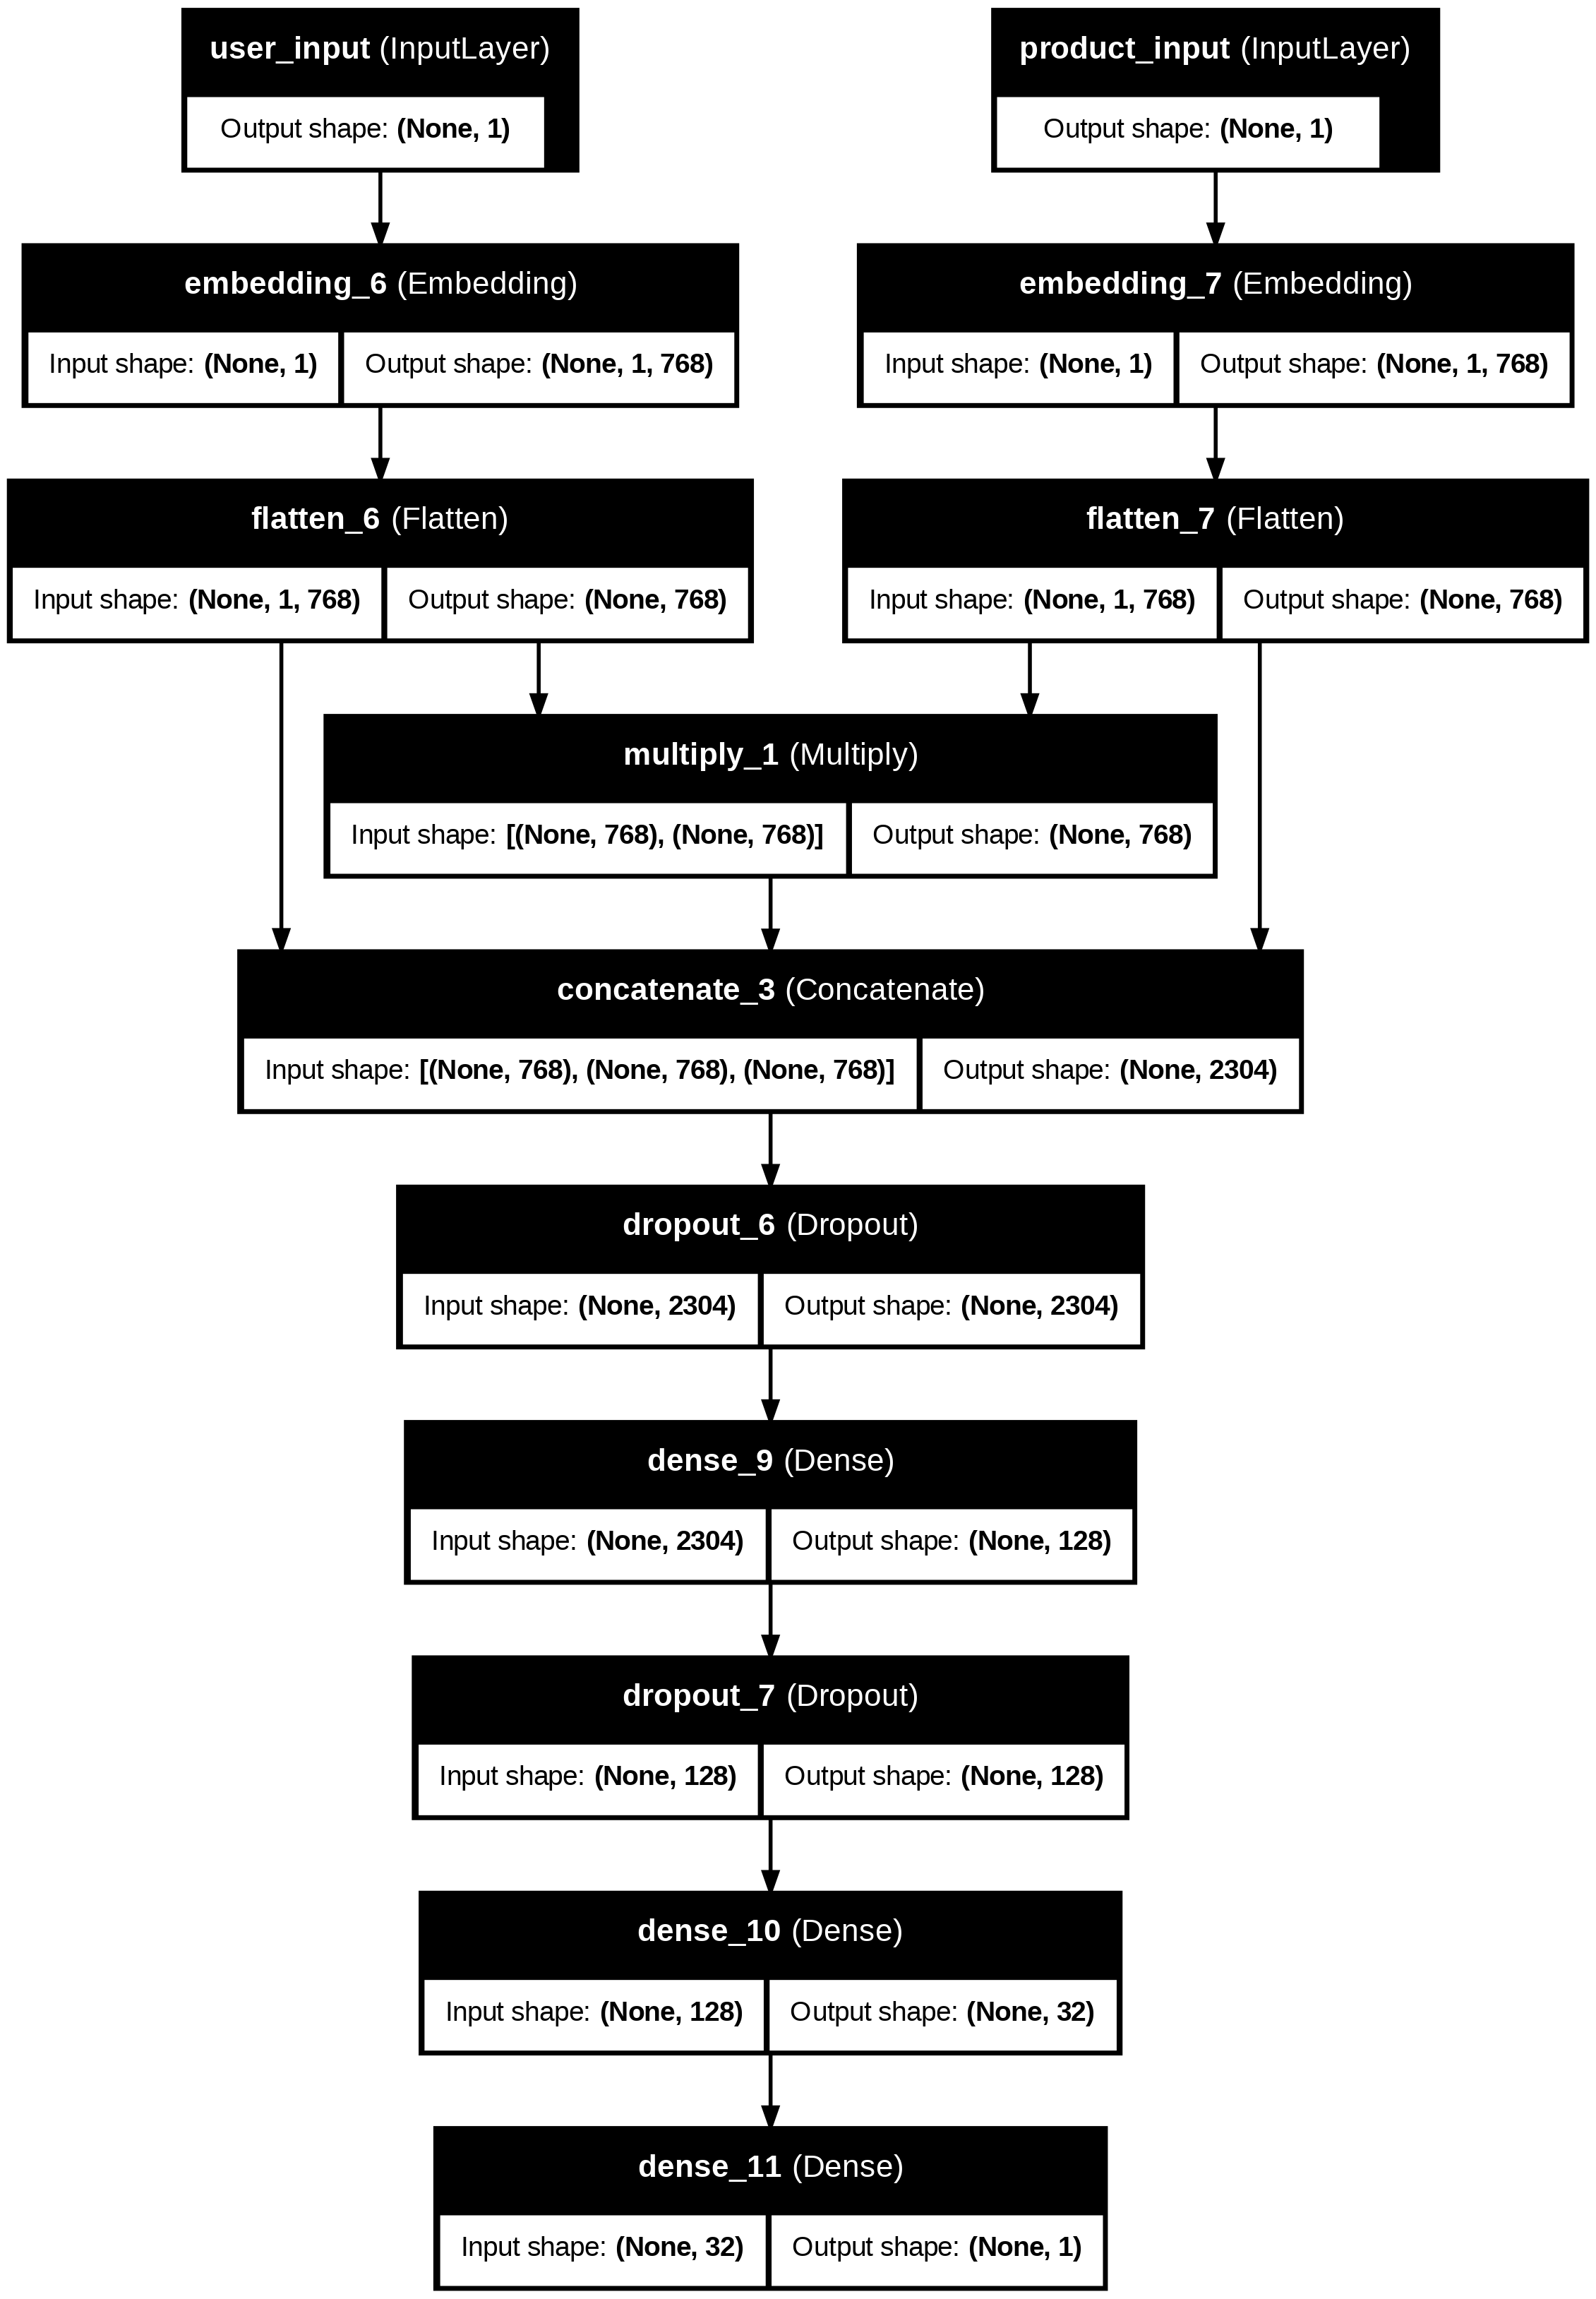

In [63]:
plot_model(model, to_file= wrk_dir + 'models/model_architecture.png', show_shapes=True, show_layer_names=True)

## Predictions - Recommendations.

In [64]:
# Predict the interactions for the test set
test_predictions = model.predict([test_user_ids, test_product_ids])

# Calculate the test MSE
test_mse = mean_squared_error(test_interactions, test_predictions)
print('Test MSE:', test_mse)

156249/156249 ━━━━━━━━━━━━━━━━━━━━ 384s 2ms/step
Test MSE: 0.0033196236


In [67]:
print(test_predictions)

array([[0.564983  ],
       [0.39585093],
       [0.5706094 ],
       ...,
       [0.75064903],
       [0.68853927],
       [0.53687614]], dtype=float32)

In [66]:
np.save(wrk_dir + "Data/test_predictions.npy",test_predictions)

## Manually Checking Recommendations

In [74]:
def find_indices_of_value(array, target_value):
    indices = [index for index, value in enumerate(array) if value == target_value]
    return indices

In [132]:
user_index = find_indices_of_value(test_user_ids, 73)
print('total user indices for user 73 : ', user_index)

product_index = [test_product_ids[index] for index in user_index]
print('total product indices for user 73 : ', product_index)

predicted_interactions = [test_predictions[index] for index in user_index]
print('total predicted interactions for user 73 : ', predicted_interactions)


total user indices for user 73 :  [445, 3744, 12712, 22725, 27073, 29773, 30872, 32664, 39359, 45526, 45600, 45944, 51502, 51577, 55797, 56298, 59680, 68641, 71737, 71919, 78114, 78988, 96277, 109922, 111792, 111822, 113374, 115126, 115127, 116015, 121756, 127618, 142213, 144686, 148666, 149342, 149790, 156915, 163133, 163201, 174646, 186302, 187962, 192152, 194118, 208809, 212087, 213771, 216162, 221533, 234443, 246139, 248410, 253113, 254536, 258390, 260294, 261542, 279717, 289981, 296071, 296962, 302605, 315094, 325830, 326379, 327468, 328827, 329542, 331165, 332375, 349294, 354517, 360404, 362075, 365577, 369576, 370585, 383780, 389174, 395536, 397724, 402326, 404461, 412043, 418498, 426349, 435443, 440577, 445576, 448438, 462183, 468945, 469032, 477559, 478654, 478679, 483896, 484610, 488630, 490306, 495289, 496131, 499735, 504733, 507680, 511194, 519794, 527253, 527615, 533085, 533543, 534321, 538492, 540306, 546871, 547404, 548064, 554382, 562073, 562541, 564517, 567258, 580430,

In [140]:
# getting top recommendations
recommend_prod_indices = [(i, val[0]) for i, val in enumerate(predicted_interactions) if val[0] >0.61]
recommend_prod_topics = [i[0] for i in recommend_prod_indices]
print(recommend_prod_topics)

[278, 334, 448, 861]


In [86]:
## Reading the data for checking the recommendations
user_grouped = pd.read_excel(wrk_dir + "Data/user_grouped_v1_3_rr.xlsx", index_col=0)
user_grouped.head()

,UserId,Review,Score,topics,new_topics
0,#oc-R103C0QSV1DF5E,say littl apprehens buy product price like kee...,5.0,9976,9976
1,#oc-R109MU5OBBZ59U,receiv free k cup sampl promot love least one ...,5.0,3470,3470
2,#oc-R10LFEMQEW6QGZ,brooklyn bean roasteri blend great tast coffe ...,5.0,11357,11357
3,#oc-R10LT57ZGIB140,shipment dog food quick howev open main box co...,3.0,332,332
4,#oc-R10UA029WVWIUI,brooklyn french roast coffe one favorit aw oka...,1.0,1763,1763


In [130]:
## Since each user had a topic and we were looking for user-topic = 1071 so we will get those rows and corresponding product topic
relevant_user_rows = user_grouped[user_grouped.new_topics == 73]
relevant_user_rows.head()

,UserId,Review,Score,topics,new_topics
2739,A115Z929RXDBY7,review white wine mustard review also complet ...,5.0,73,73
3574,A11M9C8K884RUY,three bag brown mustard seed good valu provid ...,5.0,73,73
4329,A120WKCUQXSN60,huge fan maill dijon mustard year brand buy ev...,1.0,73,73
5656,A12RAP0ZY1UNVH,grew mustard pickl usn found unavail retir ari...,5.0,73,73
6481,A137N4ET8MKC6Y,mustard tastiest lifetim far bought gift found...,5.0,73,73


In [90]:
# getting all items
product_grouped = pd.read_excel(wrk_dir + "Data/prod_grouped_v1_3_rr.xlsx", index_col=0)
print(product_grouped.head())

    ProductId                                             Review     Score  \
0     6641040  day person say chicken soup probabl go follow ...  4.351351   
1  2734888454  dog love chicken product china wont buy anymor...  3.500000   
2  2841233731  book easi read ingredi avail store unlik recip...  5.000000   
3  7310172001  product health snack pup made beef liver puppi...  4.751445   
4  7310172101  product health snack pup made beef liver puppi...  4.751445   

   topics  new_topics  
0    1629        1629  
1     838         838  
2    4889        4889  
3    1583        1583  
4    1583        1583  


In [142]:
# Getting recommended Items/Products for user - topic 1071
recommended_items = product_grouped[product_grouped.topics == recommend_prod_topics[3]]
recommended_items['Review']

,Review
2054,item ship fast use onion week let soak bit ad ...
8188,order pack price great hard rock order hard ro...
24043,basic go store look bag regist get product hap...
52733,order amazon direct muir glen almost year ever...
58334,purchas product sure purchas smucker jam jelli...
65722,cooki get costco across countri mine happi fin...


In [143]:
relevant_user_rows['Review'][4329]

'huge fan maill dijon mustard year brand buy even though cheap well replac last bottl anoth appear label size product said maill dijon original label notic word hot small letter sideway right hand edg label blew sinus fan hot mustard product ined mostli use mustard mix good apricot jam hfc marinad pork tenderloin part reduc half nice sauc meat product useless make search everi local market everi one carri maill everi jar say hot edg label look mild dijon mustard specif recip product avoid shame shame'

In [144]:
recommended_items['Review'][8188]

'order pack price great hard rock order hard rock box got expir wast money wish amazon better job check product sold defeat whole purpos buy groceri like non perish item websit instead buy local groceri amazon succeed groceri busi need better job vendor product verif term qualiti purchas case feel great valu qualiti good satisfi custom fresh receiv alot case excel buy awar refriger open'